# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Rescaling, Conv2D, MaxPooling2D, Flatten, Dense)
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

SEED = 2024
set_random_seed(SEED)

**<-- Mount Drive manually**

In [2]:
DATA_PATH = '/content/drive/MyDrive/notebooks/swoc_s4/facial_emotion_detection/'
images = np.load(f'{DATA_PATH}/images.npy')
labels = np.load(f'{DATA_PATH}/labels.npy')

# Data overview

In [3]:
images.shape, labels.shape

((19950, 48, 48, 3), (19950, 4))

In [4]:
labels[:3]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

* Number of samples: 19950
* Image resolution: 48 x 48 (x 3 channels for RGB)
* Labels: one-hot encoded


In [5]:
# converting to one-hot encoded to ordinal labels
ord_labels = np.argmax(labels, axis=1)
ord_labels[:3]

array([3, 3, 2])

**Proportion of classes in dataset**

In [6]:
values, counts = np.unique(ord_labels, return_counts=True)
dict(zip(values, counts))

{0: 3850, 1: 7200, 2: 5100, 3: 3800}

Label mapping from data source:


In [7]:
label_mapping = {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'surprised'}

**Visualizing some samples**

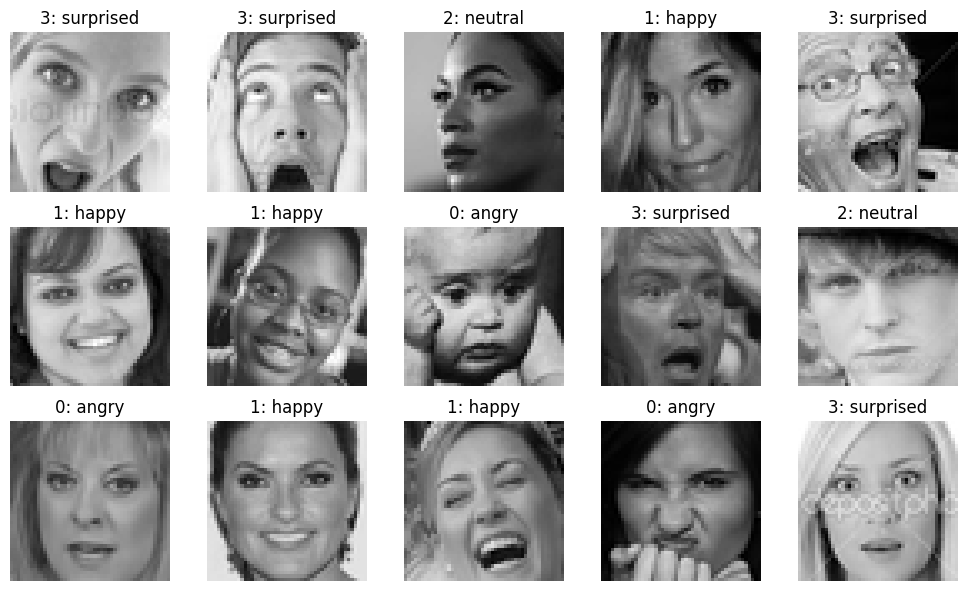

In [8]:
plt.subplots(3, 5, figsize=(10, 6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.title(f'{ord_labels[i]}: {label_mapping[ord_labels[i]]}')
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

**Issues** (and possible solutions):
* Image quality is poor due to low resolution (image upscaling: using interpolation algorithms as well as deep learning methods)
* Some samples in the visualized images have watermarks, which may interfere with the learning process (preprocessing techniques for watermark removal)
* Imbalance in labels (resampling/class-weights) [low priority issue]

# Data preparation

Creating test dataset for checking model performance on unseen data:

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, ord_labels,
    test_size=0.1,
    shuffle=True,
    stratify=ord_labels, # to maintain proportion of classes in test data
    random_state=SEED)

In [10]:
len(train_labels), len(test_labels)

(17955, 1995)

Creating validation dataset for early stopping mechanism of model training:

In [11]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.1,
    shuffle=True,
    stratify=train_labels, # to maintain proportion of classes in val data
    random_state=SEED)

In [12]:
len(train_labels), len(val_labels)

(16159, 1796)

# Model training:

We will build a convolutional neural network as our baseline model.

In [13]:
def build_model():
    model = tf.keras.Sequential([
        Rescaling(scale=1./255, input_shape=(48, 48, 3)),
        Conv2D(48, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax') # number of classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # for ordinal labels
        metrics=['accuracy']
    )

    return model

**Model summary**

In [14]:
model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 48)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        27712     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          3

**Fit model**
* High number of epochs to avoid underfitting
* Early stopping mechanism to avoid overfitting

In [15]:
%%time
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=2e-4,
    restore_best_weights=True)

history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=100,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=0)

CPU times: user 27.7 s, sys: 1.19 s, total: 28.9 s
Wall time: 42.9 s


**Validation accuracy** (using best weights from early stopping)

In [16]:
model.evaluate(val_images, val_labels)

57/57 [==============================] - 0s 5ms/step - loss: 0.7887 - accuracy: 0.7105


[0.7886693477630615, 0.7104676961898804]

**Visualizing training curves**

In [17]:
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    num_epochs = len(train_loss)
    epochs = range(num_epochs)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')

    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')

    train_stop = (num_epochs-6, val_accuracy[num_epochs-6])
    ax[1].annotate(f'Early stopping\ntriggered',
                xy=train_stop, xycoords='data',
                xytext=(0, -100), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom')

    ax[0].minorticks_on(); ax[1].minorticks_on()
    ax[0].set_xlabel('Epochs'); ax[1].set_xlabel('Epochs')
    ax[0].legend(); ax[1].legend()
    fig.tight_layout()
    plt.show()

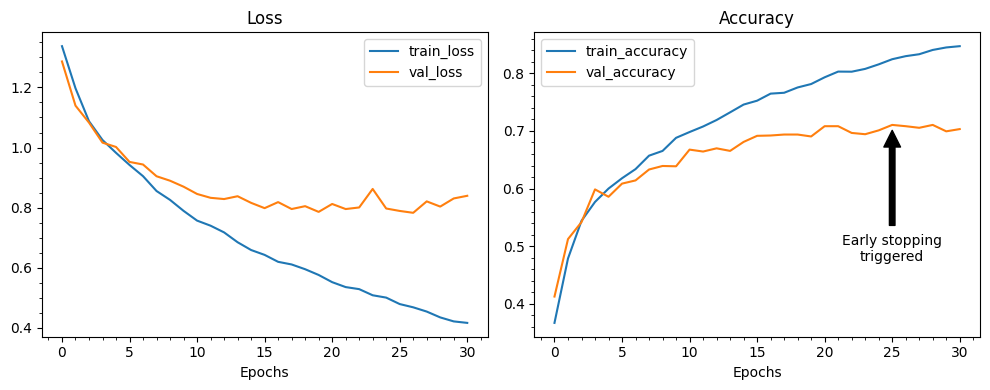

In [18]:
plot_training_curve(history)

# Performance on test (unseen) data

**Test accuracy**

In [19]:
model.evaluate(test_images, test_labels)

63/63 [==============================] - 0s 5ms/step - loss: 0.7930 - accuracy: 0.7123


[0.7929964065551758, 0.7122806906700134]

Model is able to replicate its validation accuracy (71.05%) on the unseen test set (71.23%).  
This shows that the model has generalized well and not simply overfit the training data.

**Confusion matrix**

In [20]:
predictions = np.argmax(model.predict(test_images), axis=1)

63/63 [==============================] - 0s 2ms/step


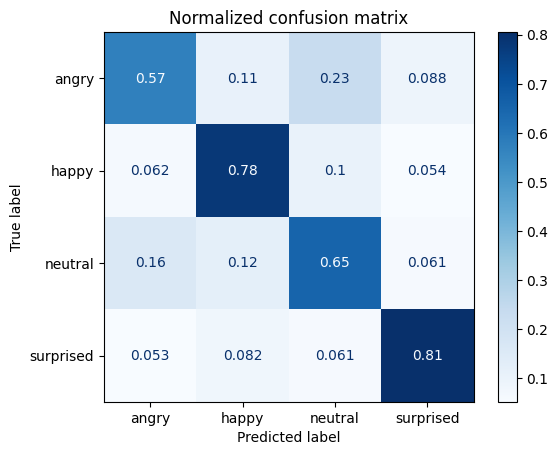

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix')
plt.show()